<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

In [1]:
#!jt -t monokai -T -N -kl
#from jupyterthemes import jtplot
#jtplot.style('grade3')

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [2]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]
y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]
roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
data = pd.read_csv('./train.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Проверка на присутствие NULL

In [6]:
data.info() #(как видим, их нет)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

TotalSpent почему то object, хотя он float. Поправим

In [7]:
data[data['TotalSpent'] == ' '] #какого то хуя пробелы

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [8]:
data['TotalSpent'] = data['TotalSpent'].map(lambda x: 0.0 if x == ' ' else float(x)) #задрочим их нахуй

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

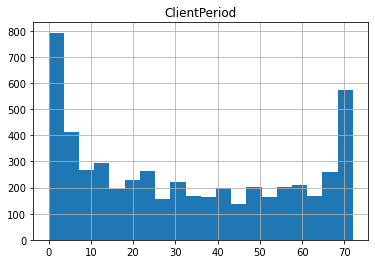

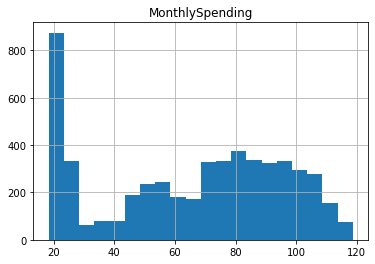

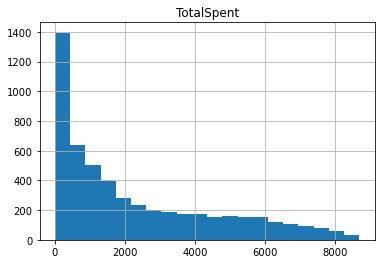

In [9]:
for i in num_cols:
    data[i].hist(bins=20)
    plt.title(i)
    plt.show()

Распеределение таргета (несбалансированное):

Text(0.5, 1.0, 'Churn')

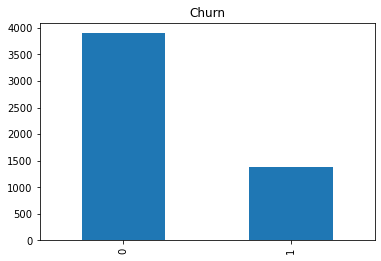

In [10]:
data['Churn'].value_counts().plot(kind='bar')
plt.title('Churn')

Посчитаем количества всего в категориальных колонках

Male      2655
Female    2627
Name: Sex, dtype: int64 



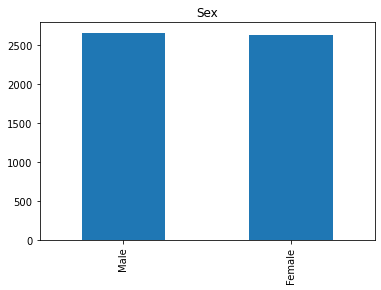

0    4440
1     842
Name: IsSeniorCitizen, dtype: int64 



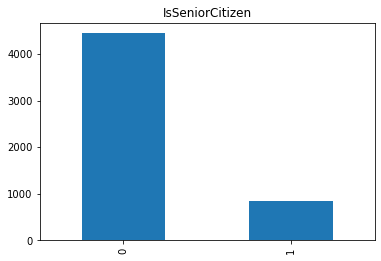

No     2705
Yes    2577
Name: HasPartner, dtype: int64 



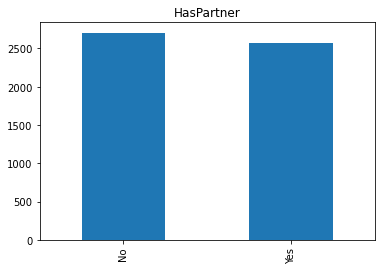

No     3676
Yes    1606
Name: HasChild, dtype: int64 



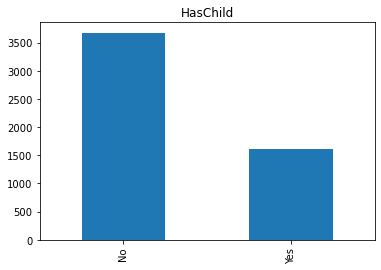

Yes    4761
No      521
Name: HasPhoneService, dtype: int64 



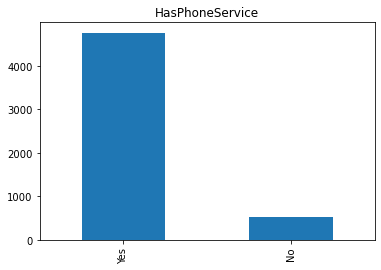

No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64 



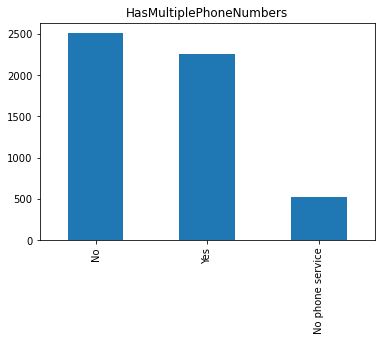

Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64 



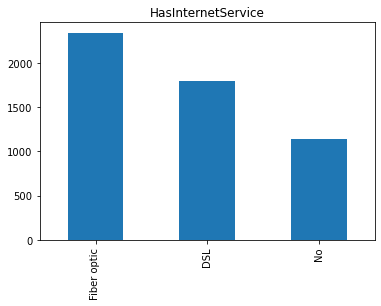

No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64 



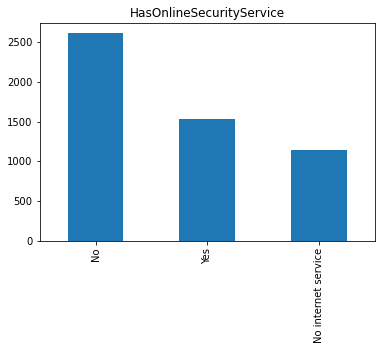

No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64 



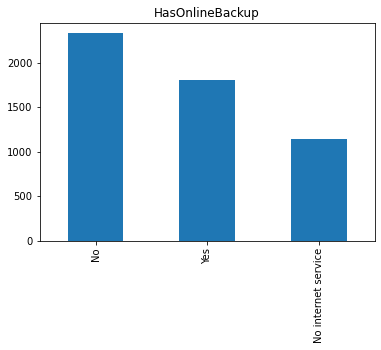

No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64 



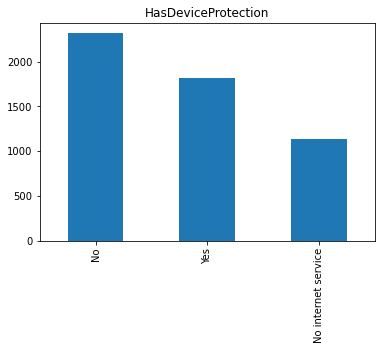

No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64 



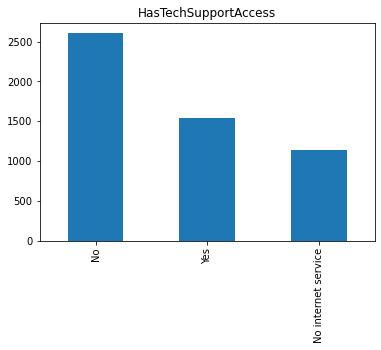

No                     2099
Yes                    2042
No internet service    1141
Name: HasOnlineTV, dtype: int64 



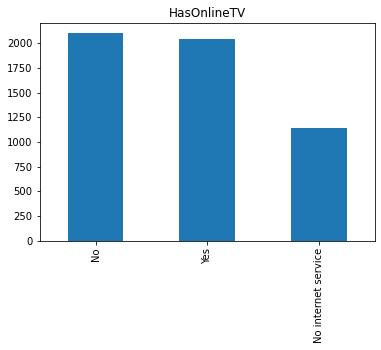

No                     2081
Yes                    2060
No internet service    1141
Name: HasMovieSubscription, dtype: int64 



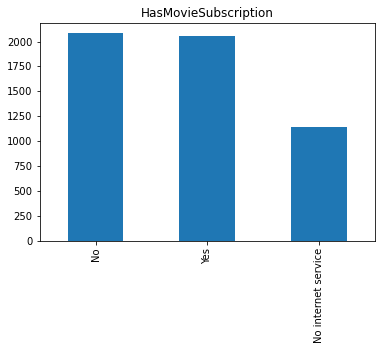

Month-to-month    2920
Two year          1280
One year          1082
Name: HasContractPhone, dtype: int64 



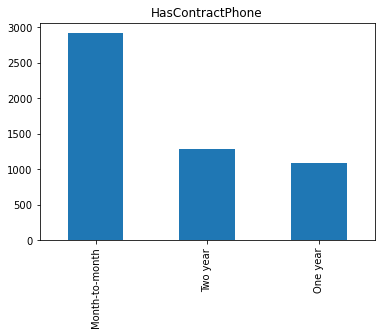

Yes    3148
No     2134
Name: IsBillingPaperless, dtype: int64 



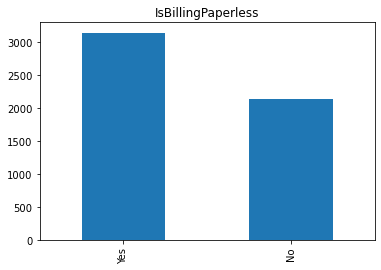

Electronic check             1786
Mailed check                 1194
Bank transfer (automatic)    1159
Credit card (automatic)      1143
Name: PaymentMethod, dtype: int64 



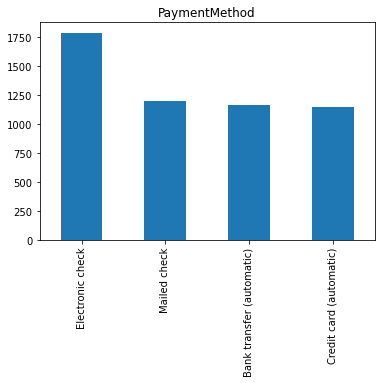

In [11]:
#fig, ax = plt.subplots(4,4,figsize=(20,6))
for i in cat_cols:
    print(data[i].value_counts(),'\n')
    data[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

In [12]:
numeric_data = data[num_cols]
categorial_data = data[cat_cols]

Посмотрим на корреляции между таргетом и признаками

In [13]:
XY = pd.concat([numeric_data, pd.get_dummies(categorial_data), data['Churn']], axis=1)

In [14]:
XY.corr()[-1::].transpose().sort_values(by=['Churn'], ascending=False)

,Churn
Churn,1.000000
HasContractPhone_Month-to-month,0.403429
HasOnlineSecurityService_No,0.352716
HasTechSupportAccess_No,0.337312
HasInternetService_Fiber optic,0.300399
PaymentMethod_Electronic check,0.296715
HasOnlineBackup_No,0.272217
HasDeviceProtection_No,0.254124
IsBillingPaperless_Yes,0.194040
MonthlySpending,0.184769


Меньше всего влияют пол, и phone service. Наверху - то, что больше всего

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [15]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier

Сделаем матрицу признаков, разделим и отнормируем

In [16]:
X = pd.concat([numeric_data, pd.get_dummies(categorial_data)], axis=1)
y = data['Churn']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
X_test

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1448,9,45.40,418.80,0,0,1,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
4792,37,70.35,2552.90,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
8,50,105.95,5341.80,0,0,1,0,1,0,1,...,1,1,0,0,1,0,0,1,0,0
3964,44,100.10,4378.35,0,0,1,1,0,1,0,...,1,0,0,1,1,0,1,0,0,0
240,25,20.95,495.15,0,0,1,0,1,1,0,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,3,34.25,139.35,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3794,30,19.70,599.25,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1
3873,8,83.55,680.05,0,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
318,34,19.60,678.80,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,1,0,0


In [19]:
clf = LogisticRegression()
params = {
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'C': [1, 10, 100, 1000, 0.1, 0.001]
}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='roc_auc', refit=True, n_jobs=-1)
clf_grid.fit(X_train_scaled,y_train)

C:\Programs\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.84844918        nan 0.84846951 0.84858252
 0.84858397 0.84857239 0.84858252 0.84857384        nan        nan
 0.84874504        nan 0.84878127 0.84878707 0.84878706 0.84878126
 0.84879573 0.84884361        nan        nan 0.84877401        nan
 0.84880881 0.84881315 0.84881895 0.8488175  0.84879723 0.84880013
        nan        nan 0.84880879        nan 0.84878707 0.84880302
 0.84880881 0.84880881 0.8488074  0.84879723        nan        nan
 0.8473519         nan 0.84742947 0.84745668 0.84746393 0.8472782
 0.84746683 0.84746538        nan        nan 0.5               nan
 0.5        0.84017355 0.8401721  0.84039113 0.84017065 0.84017355]
  warnings.warn(
C:\Programs\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was r

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 0.1, 0.001],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [20]:
LogisticPredicts=clf_grid.predict(X_test_scaled)

Получили результат

In [21]:
roc_auc_score(y_test, clf_grid.predict_proba(X_test_scaled)[:, 1])

0.8276936858728678

In [22]:
clf_grid.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [23]:
# YOUR CODE

In [24]:
numeric_data_normed=scaler.fit_transform(numeric_data)
X_cat= pd.concat([pd.DataFrame(numeric_data_normed), categorial_data], axis=1)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=42)

In [25]:
X_train_cat

,0,1,2,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4556,-0.056909,0.285854,-0.084993,Female,1,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
1468,1.083713,1.164105,1.651669,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Mailed check
3142,1.124450,1.129306,1.644198,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check
2093,-1.075322,0.295796,-0.831346,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
1505,1.613288,-1.331453,-0.188813,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,-0.749430,0.885716,-0.434799,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check
3772,-0.545747,0.274254,-0.373049,Female,0,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
5191,0.717084,-1.470648,-0.536503,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
5226,-0.993849,0.648754,-0.716155,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Bank transfer (automatic)


In [26]:
classifier = CatBoostClassifier(verbose = False,cat_features=cat_cols)
classifier.fit(X_train_cat, y_train_cat)

In [27]:
prediction = classifier.predict_proba(X_test_cat)
print(prediction)

[[0.4393811  0.5606189 ]
 [0.77763981 0.22236019]
 [0.73454608 0.26545392]
 ...
 [0.42507228 0.57492772]
 [0.99115135 0.00884865]
 [0.98960893 0.01039107]]


In [28]:
print("Best ROC-AUC is {0}".format(roc_auc_score(y_test_cat, prediction[:, 1])))

Best ROC-AUC is 0.823387759625419


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [29]:
best_model = clf_grid

In [30]:
X_raw = pd.read_csv('./test.csv')

In [31]:
X_raw

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1758,2,91.45,171.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


In [32]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [33]:
X_raw['TotalSpent'] = X_raw['TotalSpent'].map(lambda x: 0.0 if x == ' ' else float(x)) 

In [34]:
numeric_data = X_raw[num_cols]
categorial_data = X_raw[cat_cols]

In [35]:
X_end = pd.concat([numeric_data, pd.get_dummies(categorial_data)], axis=1)

In [39]:
X_end 

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,42,56.10,2386.85,0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,1,0,0
1,29,98.50,3004.15,1,0,1,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
2,9,76.25,684.85,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,67,74.00,4868.40,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,0
4,71,20.10,1389.60,0,1,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555.00,0,1,0,0,1,1,0,...,1,0,0,1,0,1,1,0,0,0
1757,13,20.85,272.35,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1
1758,2,91.45,171.45,0,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1759,19,89.10,1620.80,0,1,0,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0


In [40]:
X_end_scaled = scaler.fit_transform(X_end)

In [48]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = clf_grid.predict_proba(X_end_scaled)[:, 1]

In [49]:
submission

,Id,Churn
0,0,0.040467
1,1,0.743491
2,2,0.688884
3,3,0.005880
4,4,0.001158
...,...,...
1756,1756,0.088711
1757,1757,0.024009
1758,1758,0.752030
1759,1759,0.673441


In [50]:

submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.